In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [16]:
df_meta = pd.read_csv('../data/HAM10000_metadata.csv')

In [62]:
df_meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [23]:
print(f"\nTotal images: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")


Total images: 10015

Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']


In [18]:
print("\nClass distribution:")
print(df_meta['dx'].value_counts())


Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


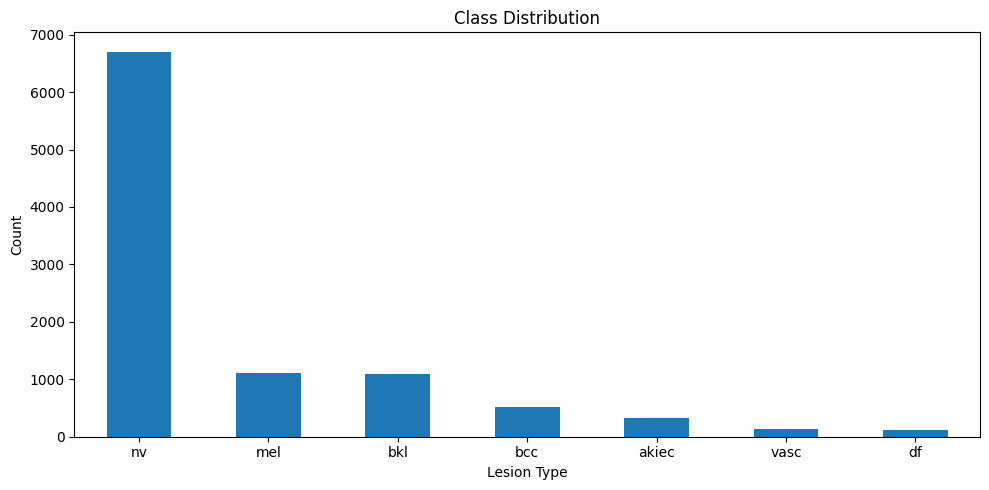

In [19]:
df_meta['dx'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Class Distribution')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
from PIL import Image
import os
import random
img_dirs = ['../data/HAM10000_images_part_1', '../data/HAM10000_images_part_2']

In [20]:
df_meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


We have data with similar lesion_id but different image_id. I want to check whether the data is a copy or a different picture of the same lesion

In [54]:
lesion_counts = df['lesion_id'].value_counts()

print("Lesions with most images:")
print(lesion_counts.head(10))

avg_lesion_c = df['lesion_id'].value_counts().mean()
print("Average Image count per Lesion {}".format(round(avg_lesion_c, 2)))

example_lesion = lesion_counts.index[0]
print(f"\nExamining lesion: {example_lesion}")

same_lesion_df = df[df['lesion_id'] == example_lesion]
print(same_lesion_df[['image_id', 'dx', 'age', 'sex', 'localization']])

Lesions with most images:
lesion_id
HAM_0000835    6
HAM_0003789    6
HAM_0005263    6
HAM_0001863    6
HAM_0007427    5
HAM_0007343    5
HAM_0002364    5
HAM_0007367    5
HAM_0000893    5
HAM_0000959    4
Name: count, dtype: int64
Average Image count per Lesion 1.34

Examining lesion: HAM_0000835
         image_id   dx   age     sex localization
807  ISIC_0025378  bkl  55.0  female         face
808  ISIC_0030394  bkl  55.0  female         face
818  ISIC_0027270  bkl  55.0  female         face
820  ISIC_0031329  bkl  55.0  female         face
868  ISIC_0026530  bkl  55.0  female         face
870  ISIC_0024409  bkl  55.0  female         face


In [27]:
image_ids = same_lesion_df['image_id'].values

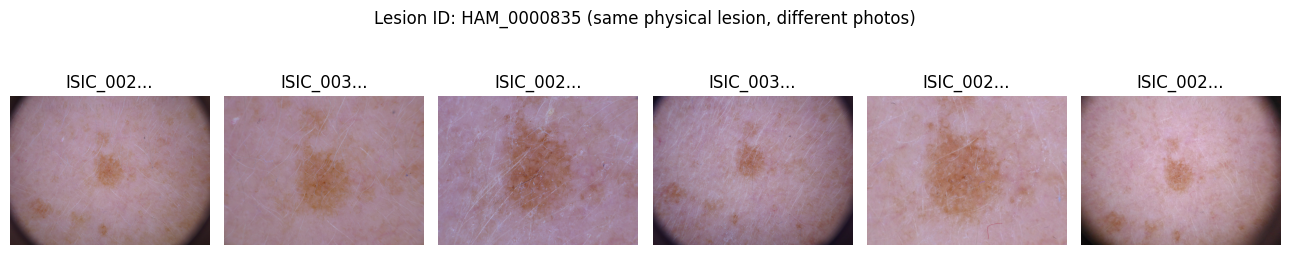

In [43]:
fig, axes = plt.subplots(1, len(image_ids), figsize=(13, 3))

for ax, img_id in zip(axes, image_ids):
    for img_dir in img_dirs:
        img_path = f"{img_dir}/{img_id}.jpg"
        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"{img_id[:8]}...")
            ax.axis('off')
            break

plt.suptitle(f"Lesion ID: {example_lesion} (same physical lesion, different photos)")
plt.tight_layout()
plt.show()

Different pictures of the same lesion, with varying magnification degree. I will probably keep them all for augmentation purposes. Also the vignette effect on some of the images can be ignored, medical artifacts can be encountered in real world data, so I'll let the model learn with this.

Train-test-split will need to be done on lesion_id and not image_id

In [57]:
lesion_dx_consistency = df_meta.groupby('lesion_id')['dx'].nunique()

inconsistent = lesion_dx_consistency[lesion_dx_consistency > 1]
print(f"Lesions with multiple diagnoses: {len(inconsistent)}")

Lesions with multiple diagnoses: 0


Quick check for inconsistencies, seems alright

In [60]:
images = df_meta['image_id'].values

dimensions = []
for img_id in images:
    for img_dir in img_dirs:
        img_path = f"{img_dir}/{img_id}.jpg"
        if os.path.exists(img_path):
            img = Image.open(img_path)
            dimensions.append(img.size)
            break

dim_df = pd.DataFrame(dimensions, columns=['width', 'height'])
print(dim_df.describe())
print(f"\nUnique dimensions:\n{dim_df.drop_duplicates()}")

         width   height
count  10015.0  10015.0
mean     600.0    450.0
std        0.0      0.0
min      600.0    450.0
25%      600.0    450.0
50%      600.0    450.0
75%      600.0    450.0
max      600.0    450.0

Unique dimensions:
   width  height
0    600     450
